# 0. Installing embedding prerequisites

If you use x86 machines or ARM (Mac M1/M2/...) chips with python 3.8, then you may benefit from `spacy` embedding.

In [ ]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 58.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Check that is works:

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

def embed(text: str):
    return nlp(line['Question']).vector

## 0.a. ARM case

Probably by the day of your lab the issue is not fixed. Then use `fasttext` of whatever.

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498208 sha256=30bc3c81157b7c11b5ecbd997cf8cadcd9c521f6e0726e0a748af23582f03998
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [ ]:
import fasttext, fasttext.util
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

def embed(text: str):
    return ft.get_sentence_vector(text)

# 00. Index data structure

And now let us install the NMSlib. To avoid M1 crashes please do not use prebuilt wheels.

In [ ]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528145 sha256=227185649b61158554e94cfbd7afa98ede5e9921b5f3e0475c4c81ecc28e210f
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib


Check it works:

In [ ]:
import hnswlib

# Generate some vectors

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Unpack it! Read it as CSV. Embed `Question`s with spacy model.

In [ ]:
!unzip /content/JEOPARDY_CSV.zip

Archive:  /content/JEOPARDY_CSV.zip
  inflating: JEOPARDY_CSV.csv        


In [ ]:
MAX = 30000
DATASET_FILENAME = '../content/JEOPARDY_CSV.csv'

In [ ]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)

print("Strings:", len(strings))

Strings: 30000


In [ ]:
import tqdm
import pickle
import os

# if vector dimension is different - please change
vectors = np.zeros((MAX, 300))

if os.path.exists('vectors'):
    print("Vectors are precomputed! Loading ...", end='')
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
    print(" done")
else:
    print("Vectors are not precomputed. Computing ...", end='')
    for i, line in enumerate(tqdm.tqdm(strings)):
        vectors[i, :] = embed(line['Question'])
    print(" dumping ...", end='')
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)
    print(" done")

Vectors are not precomputed. Computing ...

100%|██████████| 30000/30000 [05:41<00:00, 87.76it/s] 


 dumping ... done


In [ ]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 300) | strings: 30000


# 1. Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [ ]:
import hnswlib

def get_index(
        vectors,
        method='hnsw',
        space='cosinesimil',
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()

    if cutoff is not None:
        vectors = vectors[:cutoff]

    # Map space names
    space_map = {'cosinesimil': 'cosine', 'l2': 'l2'}
    space_name = space_map.get(space, 'cosine')

    # Create index
    dim = vectors.shape[1]
    num_elements = vectors.shape[0]

    index = hnswlib.Index(space=space_name, dim=dim)

    if method == 'hnsw':
        index.init_index(
            max_elements=num_elements,
            ef_construction=efConstruction,
            M=M
        )
        index.set_ef(efSearch)
    else:  # brute force
        index.init_index(max_elements=num_elements, ef_construction=efConstruction, M=M)
        index.set_ef(num_elements)  # search all for brute force

    index.add_items(vectors, np.arange(num_elements))

    return index


# should return the list of ids, sorted by dist from closest
def find_for_vector(index, vector, nn) -> list:
    # TODO your code here
    ids, dists = index.knn_query(vector, k=nn)
    return list(ids[0])


# should return list of lists of indices. Outer list is len(batch), inner lists are `nn`
def find_for_batch(index, batch, nn) -> list:
    ids, dists = index.knn_query(batch, k=nn, num_threads=8)
    return [list(row) for row in ids]

## Construct buckets with ground truth

In [ ]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra',
          'cooking', 'armory', 'war', 'history', 'money', 'books',
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry',
          'stars', 'science fiction', 'languages', 'clothes']
bucket_vectors = [embed(t) for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect ACCURATE nearest neighbours with flat index (no index)

In [ ]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [ ]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [ ]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    ground_truth[cutoff] = bucket_results

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [ ]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    # your code here
    a = sorted_result[:N]
    b = sorted_ground_truth[:N]
    return len(set(a).intersection(b)) / N

In [ ]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0


Discuss the values.
- Why do you see these numbers?
- Why are they equal?

# 2. Test HNSW

Create an index with default settings and assess its recall numbers.

In [ ]:
hnsw = get_index(vectors, method='hnsw')

In [ ]:
vector_id = 6
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [10,50 ,100,500, 1000,1500, 2000, 5000, 15000]:
    ids = find_for_vector(hnsw, bucket_vectors[5], nn=n)
    print(f"recall@{n} =", recall(ids, ground_truth[DS[-1]][5], n))

recall@10 = 0.9
recall@50 = 0.94
recall@100 = 0.94
recall@500 = 0.984
recall@1000 = 0.994
recall@1500 = 0.6666666666666666
recall@2000 = 0.5
recall@5000 = 0.2
recall@15000 = 0.06666666666666667


Discuss: why recall drops with the growth of N?

# 3. Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [ ]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

In [ ]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()

    # todo write here the code to construct index object given provided hyperparameters
    I = get_index(
        vectors,
        method='hnsw',
        efConstruction=ef,
        efSearch=ef,
        M=M,
        cutoff=D
    )
    build_time = time.time() - start

    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.

    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)

    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results)

    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

100%|██████████| 60/60 [05:26<00:00,  5.44s/it]


In [ ]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100",
           "search time 1000", "recall@100", "recall@1000", "recall@100*"]
d = {}
for i, h in enumerate(headers):
    d[headers[i]] = [r[i] for r in result]

df = pd.DataFrame(d)
# df.to_pickle('results.pkl')
df

,M,D,ef,build time,search time 100,search time 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,0.400195,0.126119,1.016902,0.978355,0.995237,0.998835
1,8,2000,200,0.492131,0.217643,1.041360,0.995600,0.996161,0.999035
2,8,2000,400,0.598093,0.322784,0.875922,0.998120,0.997577,0.999025
3,8,5000,100,0.659710,0.162942,1.105762,0.954930,0.987765,0.998010
4,8,5000,200,1.564294,0.495253,1.204204,0.988990,0.992318,0.998765
5,8,5000,400,1.372593,0.449190,1.144577,0.997060,0.993903,0.998920
6,8,10000,100,1.227274,0.188774,1.463429,0.929725,0.979789,0.996380
7,8,10000,200,2.108974,0.691149,2.237662,0.979775,0.985873,0.997735
8,8,10000,400,3.198605,0.640938,1.619241,0.994645,0.988598,0.998150
9,8,20000,100,2.790134,0.383767,3.128559,0.904645,0.969437,0.994190


Discuss, how parameters (using the table) affect perfromance?

### * Load results (if needed)

(NB: for some reason `pyplot` does not survive together with `nmslib` in Windows. So you may save we save and load).

In [ ]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", "search time 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
# df = pd.read_pickle('results.pkl')

## Displaying results

Let us display them now!

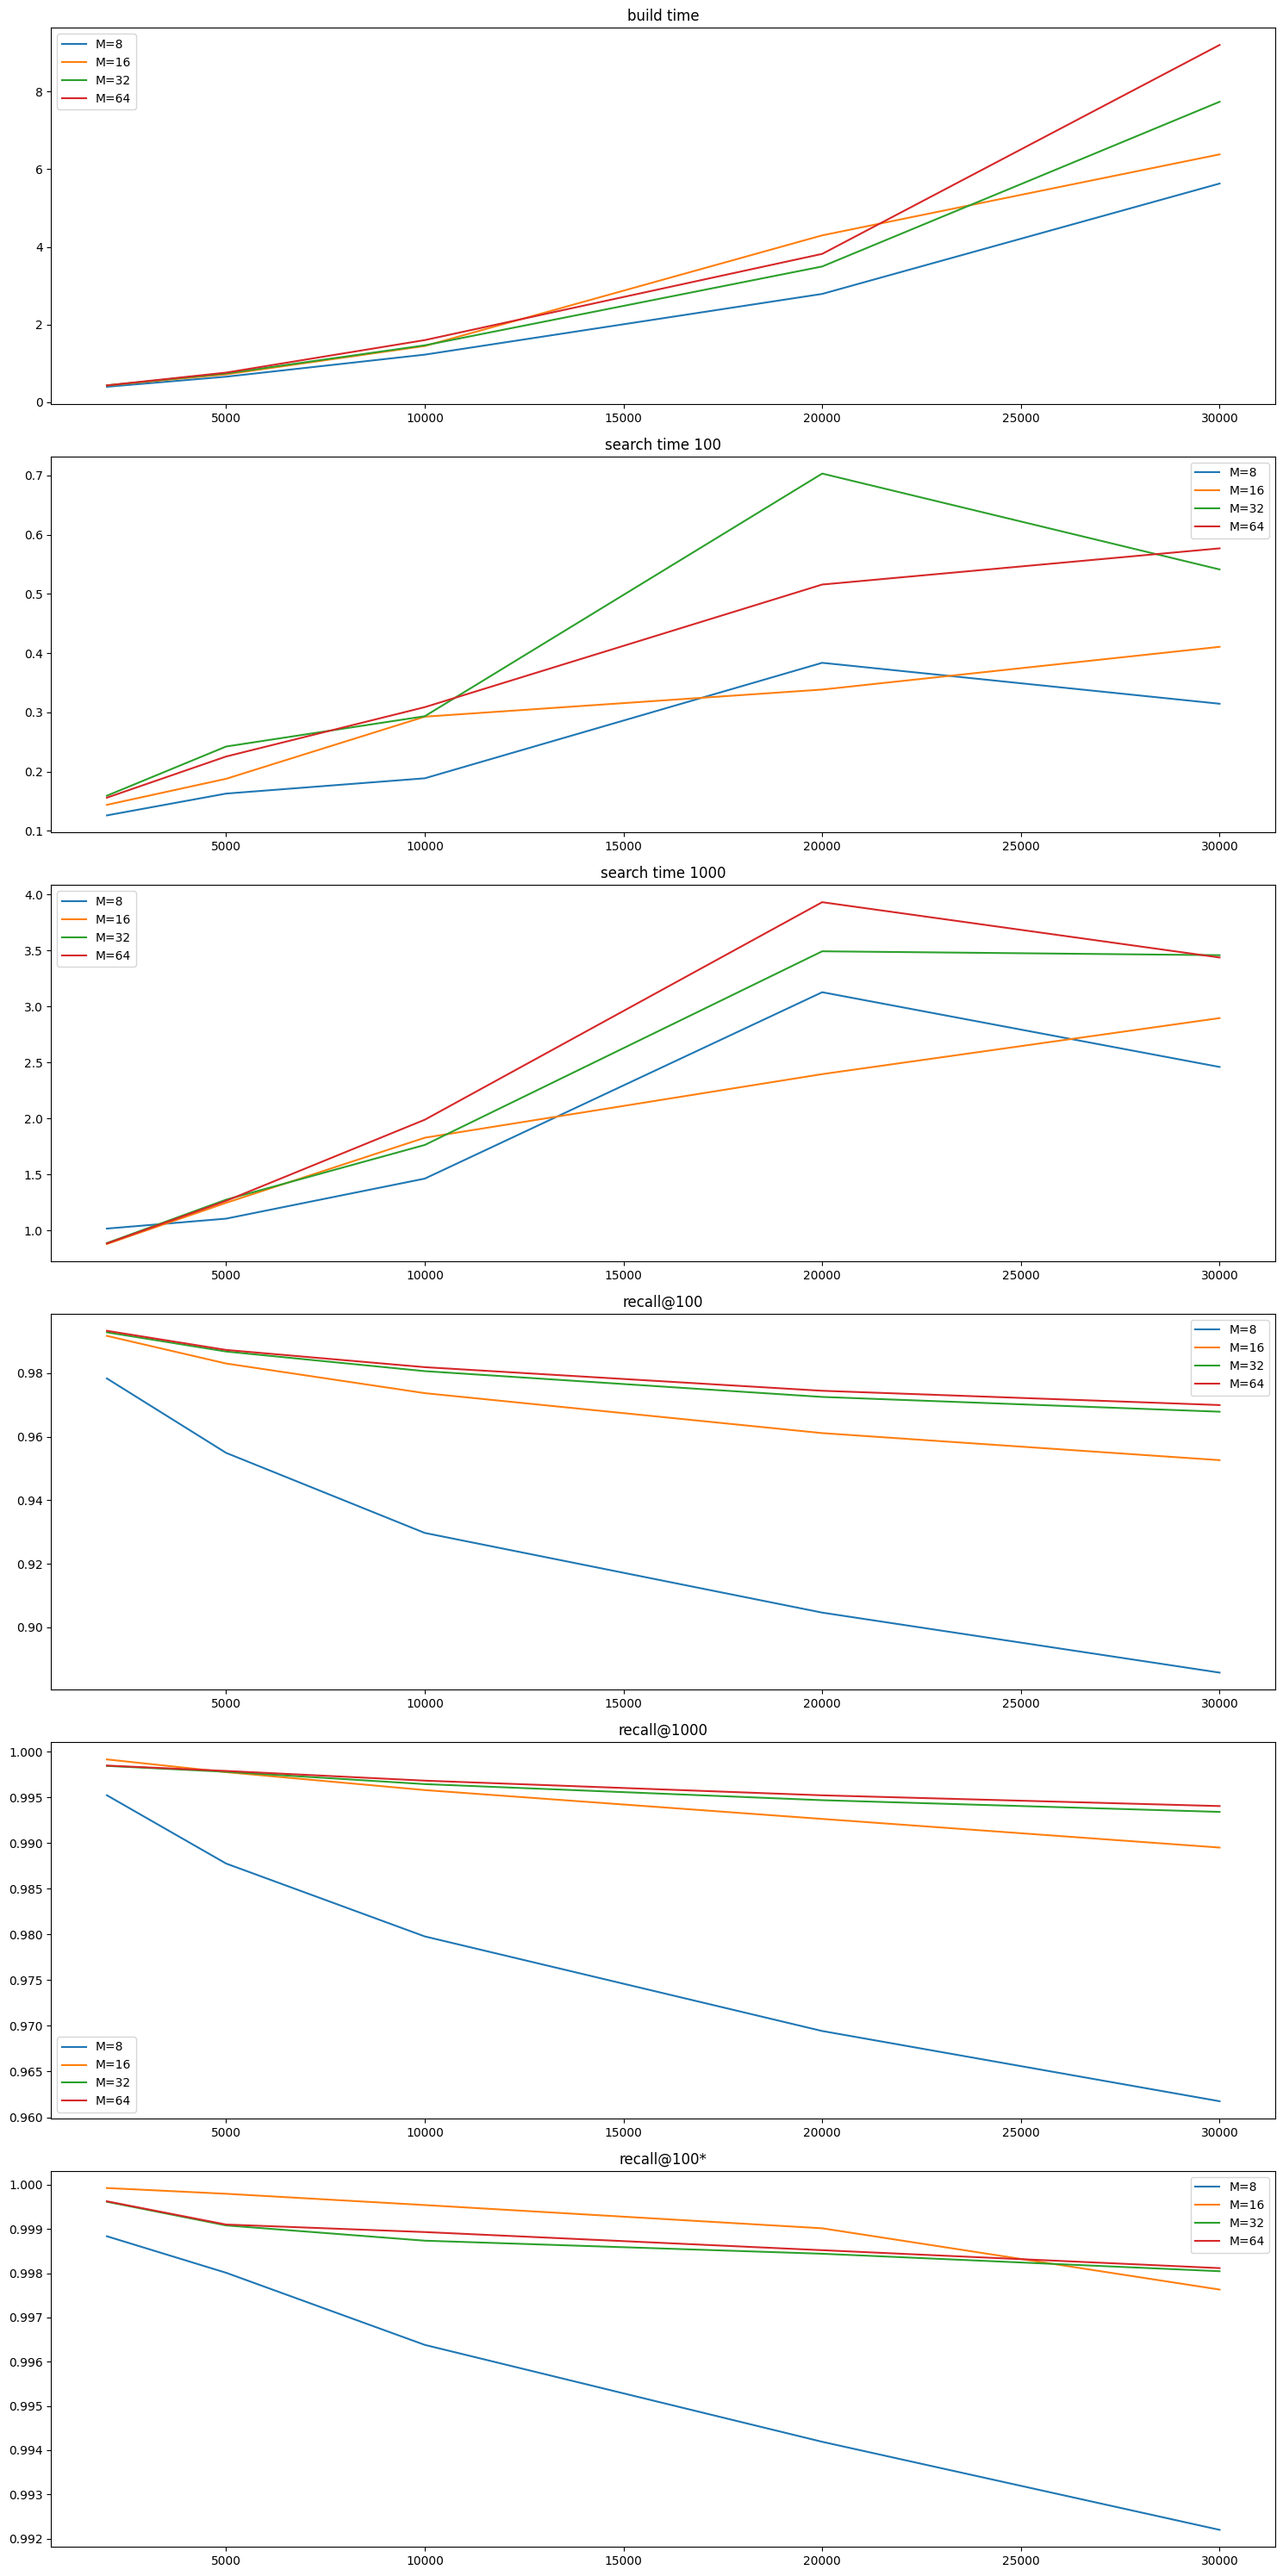

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        # print(MS[j], k)
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()

plt.tight_layout()
plt.show()